In [208]:
import cv2
from skimage import io
from preprocessing import Preprocessing
from detect import LicenceDetection
import numpy as np
from scipy import ndimage
from skimage import io
from skimage.filters import  sobel_v,threshold_otsu,sobel
from commonfunctions import *
import pytesseract

# Preprocessing Testing

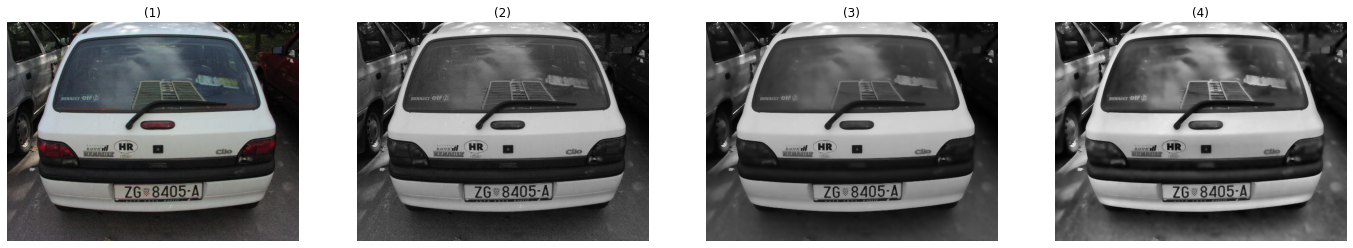

In [209]:
img = io.imread("images/sample2.jpg")
grayImage = Preprocessing.grayScale(img)
noiseFreeImage = Preprocessing.removeNoise(grayImage)
equalizedImage = Preprocessing.equilizeHistogram(noiseFreeImage)

show_images([img, grayImage, noiseFreeImage, equalizedImage])

# Verical Edge Detection Testing

(480, 640)
(482, 642)


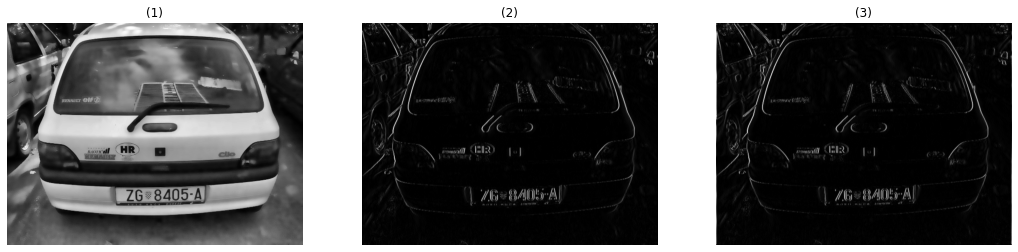

In [210]:
detectedVerticalEdgesMap = np.abs(sobel_v(equalizedImage))
sobelFilter = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
verticalEdgesDetectedImage = np.abs(convolve2d(equalizedImage, sobelFilter))

# print(equalizedImage)
# print(np.max(equalizedImage))
# equalizedImage = equalizedImage / np.max(equalizedImage)
# print(equalizedImage)
# print(np.max(equalizedImage))
# print(detectedVerticalEdgesMap)
# print(np.max(detectedVerticalEdgesMap))
# print(verticalEdgesDetectedImage)
# print(np.max(verticalEdgesDetectedImage))
print(detectedVerticalEdgesMap.shape)
print(verticalEdgesDetectedImage.shape)
show_images([equalizedImage, detectedVerticalEdgesMap, verticalEdgesDetectedImage])

# Weighted Edges Map Testing

In [211]:
print(np.mean(detectedVerticalEdgesMap))
print(np.mean(detectedVerticalEdgesMap.reshape(-1)))
weightedEdges = LicenceDetection.getWeightedEdges(detectedVerticalEdgesMap)

0.02093117468341503
0.02093117468341503


# Initial ROI Region Testing

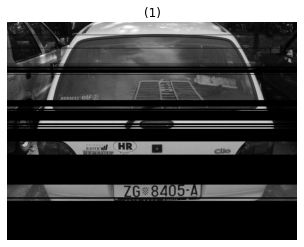

[[263, 291], [358, 393]]
0 , Roi Start =  0
0 , Roi Start =  0 , Roi End =  0
1 , Roi Start =  0 , Roi End =  0
2 , Roi Start =  0 , Roi End =  0
3 , Roi Start =  0 , Roi End =  0
4 , Roi Start =  0 , Roi End =  0
5 , Roi Start =  0 , Roi End =  0
6 , Roi Start =  0 , Roi End =  0
7 , Roi Start =  0 , Roi End =  0
8 , Roi Start =  0 , Roi End =  0
9 , Roi Start =  0 , Roi End =  0
10 , Roi Start =  0 , Roi End =  0
11 , Roi Start =  0 , Roi End =  0
12 , Roi Start =  0 , Roi End =  0
13 , Roi Start =  0 , Roi End =  0
14 , Roi Start =  0 , Roi End =  0
15 , Roi Start =  0 , Roi End =  0
16 , Roi Start =  0 , Roi End =  0
17 , Roi Start =  0 , Roi End =  0
18 , Roi Start =  0 , Roi End =  0
19 , Roi Start =  0 , Roi End =  0
20 , Roi Start =  0 , Roi End =  0
21 , Roi Start =  0 , Roi End =  0
22 , Roi Start =  0 , Roi End =  0
23 , Roi Start =  0 , Roi End =  0
24 , Roi Start =  0 , Roi End =  0
25 , Roi Start =  0 , Roi End =  0
26 , Roi Start =  0 , Roi End =  0
27 , Roi Start =  0 ,

In [212]:
rowVariance = np.var(weightedEdges, axis = 1)
# print(rowVariance)
# Get the threshold
threshVarMax = max(rowVariance) / 3
roiImage = np.zeros(weightedEdges.shape)
# print(roiImage, "\n")
roiImage[rowVariance > threshVarMax, :] = grayImage[rowVariance > threshVarMax, :]
# print(roiImage)
roi = LicenceDetection.initialRoiRegion(weightedEdges, grayImage)
show_images([roiImage])
print(roi)
roiSum = np.sum(roiImage, axis = 1)
roiStart = 0
roiEnd = 0
roiRegions = []
# print(roiSum)
inRegion = False
for i in range(len(roiSum)):
    if roiSum[i] != 0 and inRegion == False:
        if len(roiRegions) != 0 and i - roiRegions[-1][1] < 10:
            print(roiRegions, i, roiRegions[-1][1])
            roiStart, _ = roiRegions.pop()
            print(roiRegions)
        else:
            roiStart = i
        inRegion = True
        print(i, ", Roi Start = ", roiStart)
    if roiSum[i] == 0 and inRegion == True:
        roiEnd = i - 1
        inRegion = False
        print(i, ", Roi End = ", roiEnd)
        
        if roiEnd - roiStart > 15:
            print(roiRegions)
            roiRegions.append([roiStart, roiEnd])
            print(roiRegions)
    print(i, ", Roi Start = ", roiStart, ", Roi End = ", roiEnd)
# show_images([roiRegions])


# Best Region Testing

0


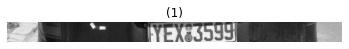

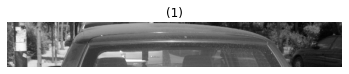

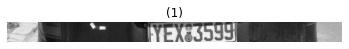

In [237]:
extractedRegionImages = []
for i in range(len(roiRegions)):
    # Get the ROI as a 2D colored image (with 3 channels)
    regionImage = img[roiRegions[i][0] : roiRegions[i][1], :]
    gray = np.float32(regionImage)
    extractedRegionImages.append(regionImage)

# show_images(extractedRegionImages)
bestRegion = 0
bestWeight = 0
for i in range(len(roiRegions)):
    regionImage = weightedEdges[roiRegions[i][0] : roiRegions[i][1], :]
    regionWeight = 0
    for k in range(regionImage.shape[0] - 1, -1, -1):
        prevEdge = 0
        for j in range(20, regionImage.shape[1] - 20):
            if regionImage[k][j] != 0:
                if prevEdge == 0:
                    regionWeight += 1
                else:
                    dist = np.abs(prevEdge - j) 
                    regionWeight += 1 / np.exp(dist)
                    # print(dist, regionWeight)
                prevEdge = j
    
    if bestWeight < regionWeight:
        bestWeight = regionWeight
        bestRegion = i
print(bestRegion)
# show_images([img[roiRegions[2][0] : roiRegions[2][1], :]])
# show_images([img[roiRegions[bestRegion][0] : roiRegions[bestRegion][1], :]])

img = io.imread("images/sample13.jpg")
preprossedImage, grayImage = Preprocessing.preprocessPhoto(img)
verticalEdges = LicenceDetection.detectVerticalEdges(preprossedImage)
weightedEdges = LicenceDetection.getWeightedEdges(verticalEdges)
initialRoiRegion = LicenceDetection.initialRoiRegion(weightedEdges, preprossedImage)
bestRoi = LicenceDetection.getBestRegion(initialRoiRegion, weightedEdges, preprossedImage)

# show_images([img, preprossedImage, grayImage])
bestRegionImage = grayImage[bestRoi[0] : bestRoi[1]]
show_images([bestRegionImage])
for roiRange in initialRoiRegion:
    show_images([grayImage[roiRange[0] : roiRange[1]]])

# Note
After multiple tests, the proposed algorithm can fail to pick the region if the image is captured from the front; an image of the rear of the car is better.

Due to shabaka :D

# Extracting the Plate Testing

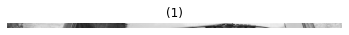

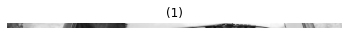

Satisfied
[[955   3]
 [955  27]] [[1407    3]
 [1407   27]]
[955   3] [1407    3] 

Appended


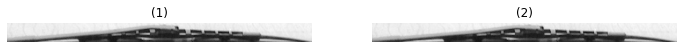

In [214]:
bestRoi = grayImage[roiRegions[1][0] : roiRegions[1][1], :]
show_images([bestRoi])
image = bestRoi.astype('uint8')
gray = cv2.bilateralFilter(image, 11, 17, 17)

# Apply some preprocessing to the region of interest in order to get the edges
edged = sobel(gray)
th = threshold_otsu(np.abs(edged))
edged = edged > th
edged = edged.astype('uint8')
show_images([gray])

# Find contours based on Edges
contours  = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Top 30 Contours
contours = contours[0] if len(contours) == 2 else contours[1]
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:50]

images = []
j = 0
for contour in contours:
    # print("Trial #", j)
    j = j + 1
    rectangle = cv2.minAreaRect(contour)
    box = np.int0(cv2.boxPoints(rectangle))
    _, start, _, end = box
    width = np.abs(end[0] - start[0])
    height = np.abs(end[1] - start[1])
    # print(width, height)
    if width > height and width > 150:
        print("Satisfied")
        xStart = min(start[0], end[0])
        xEnd = max(start[0], end[0])
        detectedLicensePlate = image[:, xStart : xEnd]
        images.append(detectedLicensePlate)
        
        sortedBasedOnX = box[np.argsort(box[:, 0])]

        pointsOfStartingVericalEdge = sortedBasedOnX[0 : 2]
        pointsOfEndingVericalEdge = sortedBasedOnX[2 :]
        print(pointsOfStartingVericalEdge, pointsOfEndingVericalEdge)

        lowerPointOfStart = pointsOfStartingVericalEdge[np.argsort(pointsOfStartingVericalEdge[:, 1])][0]
        lowerPointOfEnd = pointsOfEndingVericalEdge[np.argsort(pointsOfEndingVericalEdge[:, 1])][0]

        print(lowerPointOfStart, lowerPointOfEnd, "\n")
    
        angle = np.rad2deg(np.arctan2(lowerPointOfEnd[1] - lowerPointOfStart[1], lowerPointOfEnd[0] - lowerPointOfStart[0]))
        detectedLicensePlate = ndimage.rotate(detectedLicensePlate, angle, cval = 255)
        # print(detectedLicensePlate)
        images.append(detectedLicensePlate)
        print("Appended")
if (len(images) == 0):
    widthOfImage = gray.shape[1]
    images.append(gray[:, widthOfImage // 4 : 3 * widthOfImage // 4])
    images.append(gray)
    
show_images(images)

0
Trial # 0


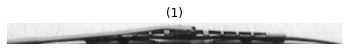


Full Licence Photo SO

Segmented Character 
Trial # 1


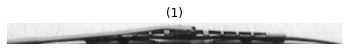


Full Licence Photo SO

Segmented Character 


In [215]:
candidates = LicenceDetection.characterSegmentation(images)
print(len(candidates))
for candidate in candidates:
    print(candidate)
# show_images(candidates[:][0])

j = 0
for image1 in images:
    licensePlateRecognition = image1.copy()

    # Image binarization using the OTSU which gets the optimal threshold based on the image histogram
    threshold = threshold_otsu(licensePlateRecognition)
    licensePlateRecognition[licensePlateRecognition <= threshold] = 0
    licensePlateRecognition[licensePlateRecognition > threshold] = 255
    contours, _ = cv2.findContours(licensePlateRecognition, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    xFunction = lambda ctr: cv2.boundingRect(ctr)[0]
    contours = sorted(contours, key = xFunction)

    pytesseract.pytesseract.tesseract_cmd = r'D:\\Programs\\Tesseract-OCR\\tesseract.exe'
    availableText = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    psmMode = 7
    tesseractConfig = f"-c tessedit_char_whitelist={availableText} --psm {psmMode}"
    detected_lpr_text = ''
    characters = []

    print("Trial #", j)
    show_images([image1])

    for contour in contours:
    # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)
        if w * h < 800 and w * h > 200:
            # Getting ROI
            roi = licensePlateRecognition[y : y + h, x : x + w]
            roi = np.pad(roi, 1, constant_values = 255)
            roi = cv2.erode(roi, None)
            text = pytesseract.image_to_string(roi, config = tesseractConfig, lang = "eng").split()
            if len(text) == 1 and text[0] in availableText:
                characters.append(roi)
                detected_lpr_text += text[0]
        
    print(detected_lpr_text)
    j += 1

    if (len(characters) != 0):
        min_shape = sorted( [(np.sum(i.size), i.size ) for i in characters])[0]
        characters_comb = []
        for char in characters:
            characters_comb.append(cv2.resize(char,min_shape, interpolation = cv2.INTER_CUBIC))

        segmented_char = cv2.hconcat(characters_comb)
    tesseractConfig = "-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 --psm 6"
    text = pytesseract.image_to_string(licensePlateRecognition, config=tesseractConfig, lang="eng")
    print('Full Licence Photo', text)
    print('Segmented Character', detected_lpr_text)